In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 7 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 1

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 3686.8595 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2022-12-31,128.757172,128.900574,128.936859,129.288574
AMZN,2022-12-31,84.000000,84.009407,84.077034,84.097641
BTC-USD,2023-01-02,16603.679688,16622.451172,16681.994141,16597.201172
GOOGL,2022-12-31,88.133713,88.153511,88.307037,88.428856
IBM,2022-12-31,130.646225,130.567352,130.635162,130.575073


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
        mae        mse      mape      rmse    smape:
0  4.709122  22.175827  0.037962  4.709122  3.725494

Model: AutoETS
        mae        mse      mape      rmse    smape:
0  4.852524  23.546987  0.039118  4.852524  3.836766

Model: AutoTheta
        mae        mse      mape      rmse    smape:
0  4.888809  23.900455  0.039411  4.888809  3.864902

Model: CES
        mae        mse      mape      rmse    smape:
0  5.240524  27.463095  0.042246  5.240524  4.137202

Results for MSFT:
Model: AutoARIMA
        mae       mse      mape      rmse    smape:
0  0.766083  0.586883  0.003238  0.766083  0.323252

Model: AutoETS
        mae       mse      mape      rmse    smape:
0  0.292358  0.085473  0.001236  0.292358  0.123485

Model: AutoTheta
        mae       mse      mape      rmse    smape:
0  0.515427  0.265665  0.002178  0.515427  0.217602

Model: CES
        mae       mse     mape      rmse    smape:
0  1.031662  1.064326  0.00436  1.031662  0.435071

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=1, n_windows=3, step_size=1, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-12-28,2022-12-27,125.010124,128.947067,126.287094,131.607040,129.060898,120.712944,137.408859,129.163071,126.865501,131.507370,129.433670,125.791977,133.095673
AAPL,2022-12-29,2022-12-28,128.550964,125.234795,122.571732,127.897865,125.158669,117.062729,133.254608,125.418671,123.115440,127.768753,126.113449,122.238091,130.029724
AAPL,2022-12-30,2022-12-29,128.868332,128.169861,125.509216,130.830521,128.500809,120.188553,136.813080,128.445175,126.139168,130.798111,127.778046,124.076248,131.794998
AMZN,2022-12-28,2022-12-27,81.820000,83.040001,79.696053,86.383949,83.054199,76.245720,89.862671,83.240524,80.351219,86.188614,83.859810,79.255135,88.490150
AMZN,2022-12-29,2022-12-28,84.180000,81.820000,78.476082,85.163918,81.831200,75.123421,88.538986,81.848541,78.959175,84.796700,81.681770,76.788208,86.626991


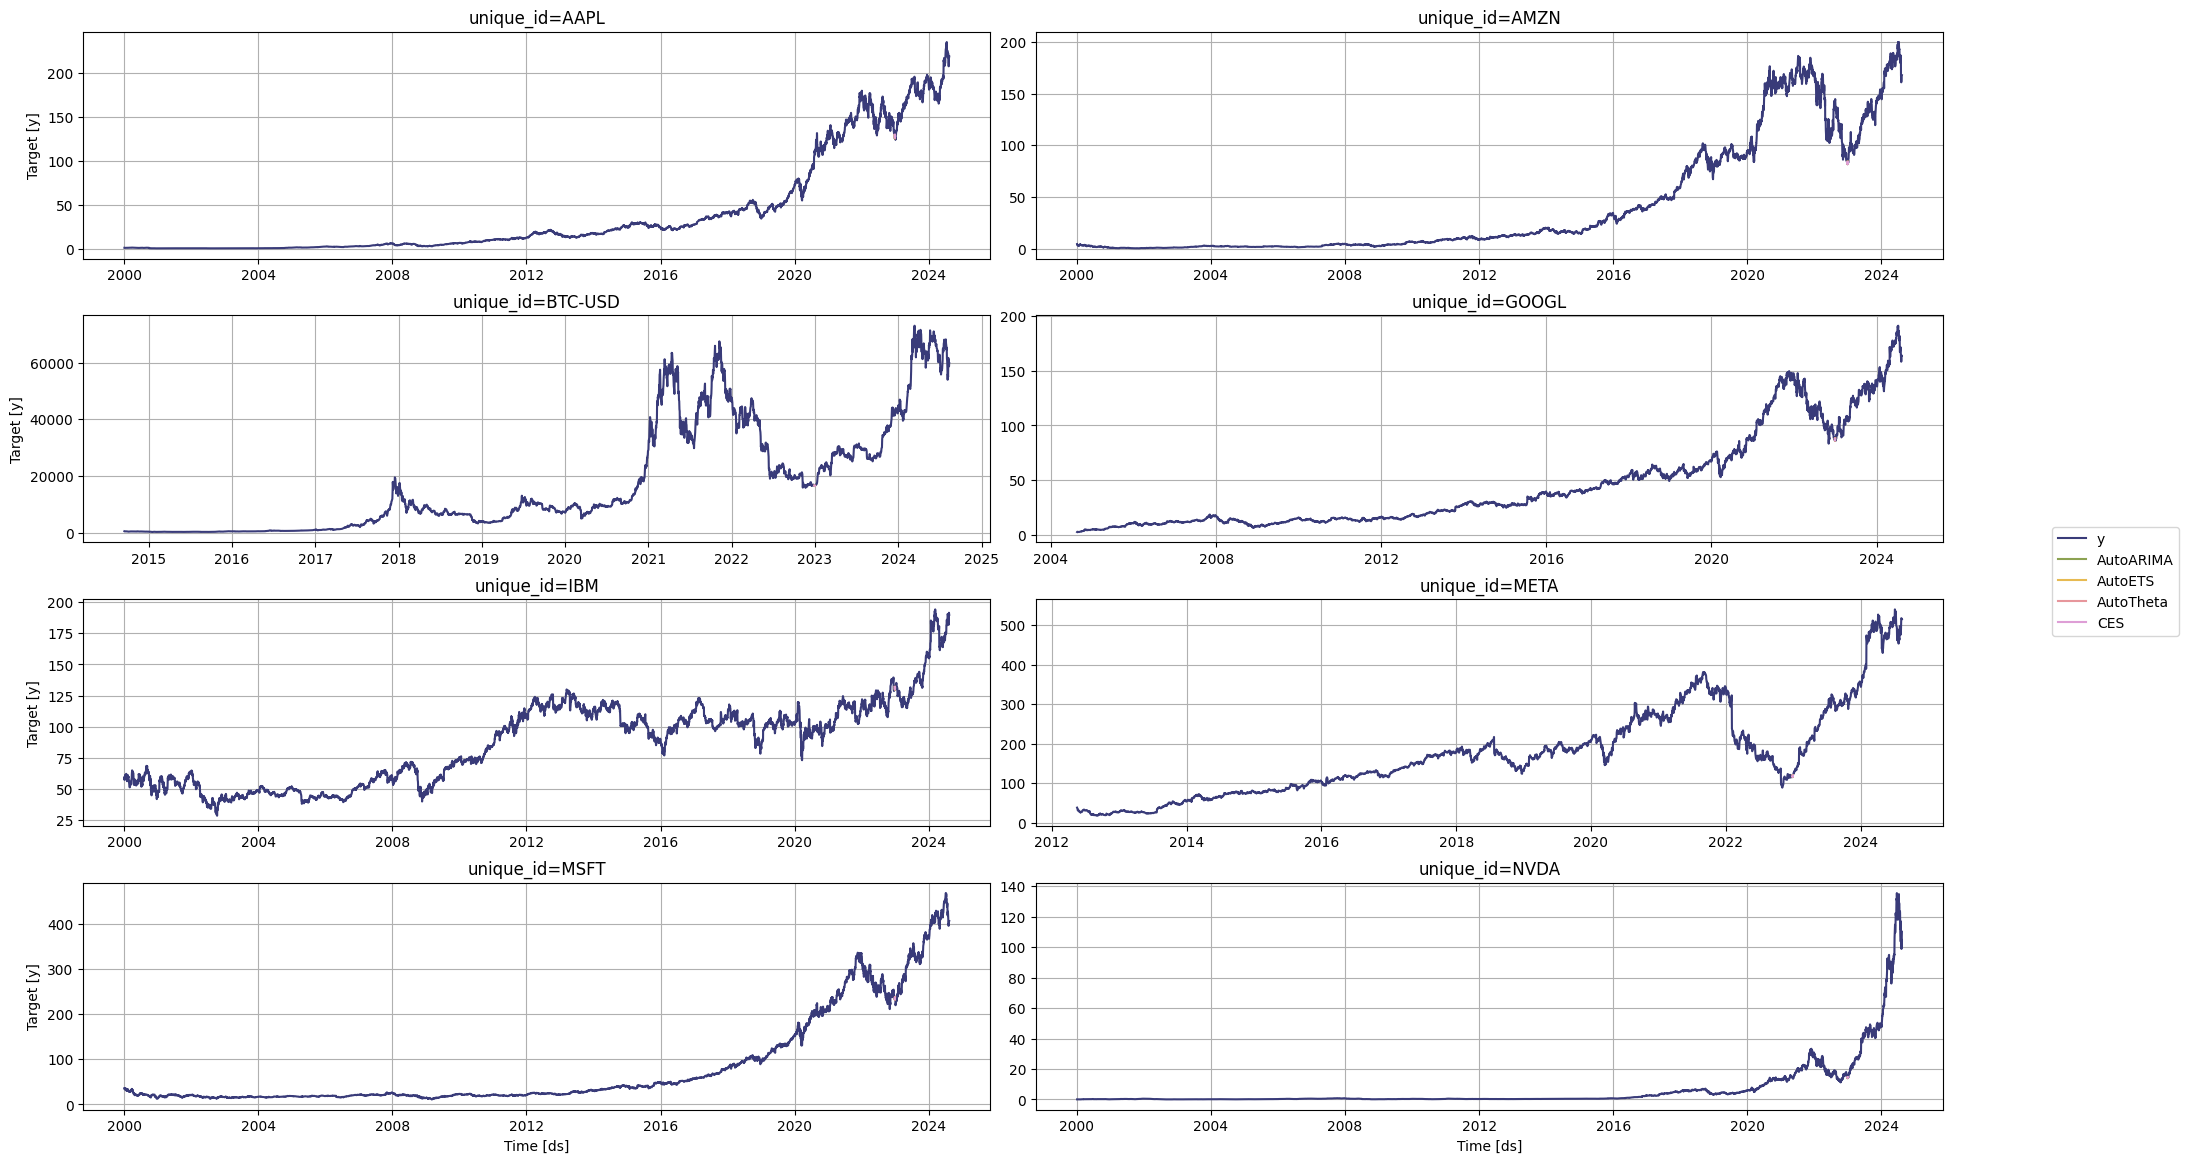

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))